In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
ENTITY_TYPE = "skill_card"

DATA_DIR = f"./data/{ENTITY_TYPE}s"
EMBEDDING_DIM = 128
BATCH_SIZE = 64
EPOCHS = 10

MODEL_SAVE_PATH = f"./{ENTITY_TYPE}_model.pt"
ONNX_SAVE_PATH = f"./{ENTITY_TYPE}_model.onnx"

In [18]:
class SmallEmbeddingNet(nn.Module):
    def __init__(self, num_classes, embedding_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 → 32
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 → 16
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # → 1×1 output
        )
        self.embedding = nn.Linear(128, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.conv(x).view(x.size(0), -1)
        emb = self.embedding(x)
        out = self.classifier(emb)
        emb = F.normalize(emb, p=2, dim=1)
        return emb, out

In [19]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.RandomResize(16, 64, antialias=False),
        v2.Resize((64, 64)),
        v2.RandomResizedCrop(64, scale=(0.9, 1.0)),
        v2.ColorJitter(0.2, 0.2, 0.2),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

num_classes = len(dataset.classes)
print("Number of classes:", num_classes)

Number of classes: 2588


In [20]:
model = SmallEmbeddingNet(num_classes, EMBEDDING_DIM).to(device)

In [28]:
class ClassifierNet(nn.Module):
    def __init__(self, num_classes, embedding_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 → 32
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 → 16
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # → 1×1 output
        )
        self.embedding = nn.Linear(128, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.conv(x).view(x.size(0), -1)
        emb = self.embedding(x)
        out = self.classifier(emb)
        return out

model = ClassifierNet(num_classes, EMBEDDING_DIM).to(device)

In [29]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location="cpu"), strict=False)
model.eval()

ClassifierNet(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (embedding): Linear(in_features=128, out_features=128, bias=True)
  (classifier): Linear(in_features=128, out_features=2588, bias=True)
)

In [30]:
dummy_input = torch.randn(1, 3, 64, 64)
dummy_input = dummy_input.to(device)
torch.onnx.export(
    model.eval(),
    dummy_input,
    ONNX_SAVE_PATH,
    input_names=["input"],
    output_names=["classifier"],
    dynamic_axes={"input": {0: "batch_size"}},
    opset_version=11,
)

In [21]:
old_state = torch.load(MODEL_SAVE_PATH, map_location="cpu")
new_state = model.state_dict()
for k in new_state.keys():
    if k in old_state and "classifier" not in k:
        new_state[k] = old_state[k]

old_w = old_state["classifier.weight"]
old_b = old_state["classifier.bias"]

new_w = new_state["classifier.weight"]
new_b = new_state["classifier.bias"]

new_w[: old_w.shape[0]] = old_w
new_b[: old_b.shape[0]] = old_b

new_state["classifier.weight"] = new_w
new_state["classifier.bias"] = new_b

model.load_state_dict(new_state)
model.eval()

SmallEmbeddingNet(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (embedding): Linear(in_features=128, out_features=128, bias=True)
  (classifier): Linear(in_features=128, out_features=2588, bias=True)
)

In [22]:
for name, param in model.named_parameters():
    param.requires_grad = name.startswith("classifier")

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
def train(model, dataloader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings, outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")
    return total_loss / len(dataloader)

In [25]:
# Run this until it's good
while True:
    loss = train(model, dataloader, optimizer, EPOCHS)
    if loss < 0.2:
        print("Training complete with acceptable loss.")
        break

Epoch [1/10], Loss: 2.8443
Epoch [2/10], Loss: 2.2361
Epoch [3/10], Loss: 1.8022
Epoch [4/10], Loss: 1.4544
Epoch [5/10], Loss: 1.2162
Epoch [6/10], Loss: 1.0332
Epoch [7/10], Loss: 0.8806
Epoch [8/10], Loss: 0.7715
Epoch [9/10], Loss: 0.6845
Epoch [10/10], Loss: 0.5728
Epoch [1/10], Loss: 0.5099
Epoch [2/10], Loss: 0.4522
Epoch [3/10], Loss: 0.4064
Epoch [4/10], Loss: 0.3755
Epoch [5/10], Loss: 0.3267
Epoch [6/10], Loss: 0.3066
Epoch [7/10], Loss: 0.2774
Epoch [8/10], Loss: 0.2621
Epoch [9/10], Loss: 0.2641
Epoch [10/10], Loss: 0.2322
Epoch [1/10], Loss: 0.2272
Epoch [2/10], Loss: 0.2117
Epoch [3/10], Loss: 0.2245
Epoch [4/10], Loss: 0.1996
Epoch [5/10], Loss: 0.1914
Epoch [6/10], Loss: 0.1969
Epoch [7/10], Loss: 0.1931
Epoch [8/10], Loss: 0.1887
Epoch [9/10], Loss: 0.1761
Epoch [10/10], Loss: 0.1872
Training complete with acceptable loss.


In [26]:
for images, labels in dataloader:
    images = images.to(device)
    labels = labels.to(device)

    print("Labels:", labels)
    _, outputs = model(images)
    print("Predicted:", outputs.argmax(dim=1))
    break

Labels: tensor([1216, 2463, 1826, 2119, 2220, 1277, 1448, 2239,  931, 2220, 1762, 2246,
        1746, 2320, 1644, 1503, 1099, 2437, 2200, 1247, 1274,  966, 1723,  430,
        1778, 1342, 1273,   71, 1671, 1874, 1229, 2137,  866, 1233, 2089, 2520,
        2507,  395,  761, 2067,  784, 2391, 1865, 2222,  696, 1271, 1972, 1297,
         267, 2067, 2403,  692, 1033, 1630,   42, 2000,  386, 1033, 1606, 2000,
         660,  882, 1269,  654], device='cuda:0')
Predicted: tensor([1216, 2463, 1826, 2119, 2220, 1277, 1448, 2239,  931, 2220, 1762, 2246,
        1746, 2320, 1644, 1503, 1099, 2437, 2200, 1247, 1274,  966, 1723,  430,
        1778, 1342, 1273,   71, 1671, 1874, 1229, 2137,  866, 1233, 2089, 2520,
        2507,  395,  761, 2067,  784, 2391, 1865, 2222,  696, 1271, 1972, 1297,
         261, 2067, 2403,  692, 1033, 1630,   42, 2000,  386, 1033, 1606, 2000,
         660,  882, 1269,  654], device='cuda:0')


In [27]:
torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [58]:
class EmbeddingOnly(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.conv = model.conv
        self.embedding = model.embedding

    def forward(self, x):
        x = self.conv(x).view(x.size(0), -1)
        return F.normalize(self.embedding(x), p=2, dim=1)

embedder = EmbeddingOnly(model).eval()
dummy_input = torch.randn(1, 3, 64, 64)
dummy_input = dummy_input.to(device)

torch.onnx.export(
    embedder,
    dummy_input,
    ONNX_SAVE_PATH,
    input_names=["input"],
    output_names=["embedding"],
    dynamic_axes={"input": {0: "batch_size"}},
    opset_version=11,
)

print(f"Exported ONNX model to: {ONNX_SAVE_PATH}")

Exported ONNX model to: ./skill_card_model.onnx


In [106]:
images, labels = next(iter(dataloader))
images = images.to(device)
_, logits = model(images)

print("Predicted:", logits[0].argmax().item())
print("True label:", labels[0].item())

Predicted: 158
True label: 158


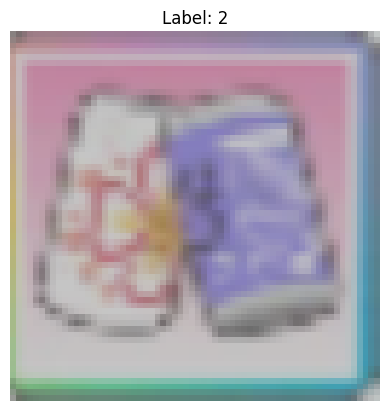

In [33]:
import matplotlib.pyplot as plt

img, label = dataset[54]
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()